Project 2 ipynb

Kelly Berdelle

Naveen Ithikkat

# Project 02 - Due Friday, November 11 at 12pm

*Objectives*: Gain experience loading a transactional dataset into a relational database model you define yourself and using SQL to explore its contents. Transform the data into a star schema, documenting the schema visually, and explore the transformed data analytically by writing and executing a number of SQL queries using common syntax and functions and describing your findings.  Gain practice working on these tasks with a partner.

*Grading criteria*: The tasks should all be completed, and questions should all be answered with SQL queries, diagrams, and charts in the space provided, unless a text answer is requested.  The notebook itself should be completely reproducible at datanotebook.org, from start to finish: another person should be able to use the same code to obtain the same results as yours.  Note that you will receive no more than partial credit if you do not add text/markdown cells explaining your thinking at each major step in each problem.

*Attestation*: **Work in pairs**.  At the end of your submitted notebook, identify the work each partner performed and attest that each contributed substantially to the work.

*Deadline*: Friday, November 11, 12pm.  One member of each pair must submit your notebook to Blackboard; you should not both submit it separately.  You may each push a copy to your own GitHub repository.


## Setup - select and obtain data

The US City Open Data Census has a variety of [transactional data from all over the country](http://us-city.census.okfn.org/).  Select one topic and one city from this Census, download the data, and explain your reason for this choice before proceeding.  Provide a link to the web page for the data set you've chosen.

I strongly encourage you to select a dataset from among the following topics:  Crime, Property Assessment, Campaign Finance Contributions, Service Requests (311), and Web Analytics.

By *transactional* data I mean records at the grain of one event per business process.  In the case of Service Requests (311), for example, that would require data at the level of each individual report of a service request.  If this isn't clear, think about the bike trip data - each individual ride was included - and look for data at that level of event/process specificity.  Avoid data like the Connecticut boating data, which was summarized by year, not individual transactions.

Please aim for a dataset of at least 10,000 individual records, but less than 250,000 records.  A little more or a little less is okay, but try to stay within these limits.

For this project, we have selected the dataset pertaining to 'Crime in Pittsburgh' to work with. 
Pittsburgh happens to be the capital city of one of the team-members' (Naveen's) home state, so we thought it would be interesting to study this dataset and see what insights we could come up with!

## Problem 1 - examine the data (20 points)

Use `csvstat`, `pandas`, or other tools as you see fit and observe the contents of your dataset.  Review important points from any metadata provided.  Describe what you see:  What do the columns mean?  Are there null values?  Which columns interest you the most?  Which columns present some opportunities, challenges, or questions you would like to ask?

First, our data came from a website that requires the user to check an "I Agree" box prior to getting access, therefore, wget does not work. We have included the data with this notebook.

The url from where the dataset has been downloaded is:
https://data.wprdc.org/dataset/pittsburgh-police-incident-blotter

We can get a quick look at the columns of the dataset using csvcut:

In [1]:
!csvcut -n c0fcc09a-7ddc-4f79-a4c1-9542301ef9dd.csv

  1: _id
  2: REPORT_NAME
  3: CCR
  4: SECTION
  5: DESCRIPTION
  6: ARREST_TIME
  7: ADDRESS
  8: NEIGHBORHOOD
  9: ZONE
 10: AGE
 11: GENDER


There are 11 columns.
Next, running csvstat will give us detailed statistics:

In [2]:
!csvstat c0fcc09a-7ddc-4f79-a4c1-9542301ef9dd.csv

  1. _id
	<class 'int'>
	Nulls: False
	Min: 1
	Max: 117108
	Sum: 6857200386
	Mean: 58554.5
	Median: 58554.5
	Standard Deviation: 33806.167660896834
	Unique values: 117108
  2. REPORT_NAME
	<class 'str'>
	Nulls: True
	Values: ARREST, OFFENSE 2.0
  3. CCR
	<class 'int'>
	Nulls: False
	Min: 10161970
	Max: 16845890
	Sum: 1826036859661
	Mean: 15592759.330370257
	Median: 15239627.5
	Standard Deviation: 502282.44244876073
	Unique values: 55386
	5 most frequent values:
		16107722:	64
		16073458:	62
		15150094:	60
		16108572:	52
		15092372:	49
  4. SECTION
	<class 'str'>
	Nulls: False
	Unique values: 539
	5 most frequent values:
		3304:	5593
		2701:	5214
		13(a)(16):	4743
		13(a)(32):	3751
		9999:	3738
	Max length: 19
  5. DESCRIPTION
	<class 'str'>
	Nulls: False
	Unique values: 1564
	5 most frequent values:
		Criminal Mischief.:	5586
		Simple Assault.:	5214
		Possession of Controlled Substance:	4743
		Paraphernalia - Use or Possession:	3751
		Theft by Unlawful Taking or Disposition.:	3437
	Max

There are 117108 rows in the dataset as of 11/3/2016 at 10:30 am. It appears that the data are updated frequently so at the time of grading, the number of rows may have increased.
The dataset captures information regarding incidents of crime such as the type of crime, and the time and place of occurrence alongwith some information of the suspect such as age and gender.
The 'id' field has unique values for each row and can be considered the primary key.
Null values are present in the Report_Name, Address, Neighbourhood, Zone, Age and Gender fields.
The max value in Age is 228 indicating possible error values.
There seem to be uncommon/error values in the Gender field such as '6' & 'OSC'.
Some interesting questions to ask would be:
- The top 10 types of crime being committed and their proportion of the total crimes. (This could help develop action plans to reduce those types of crimes from being committed.) 
- Which hours of the day see more arrests. (This could help with planning police staffing.)
- Which neighborhoods are prone to more crime. (This could help police focus on 'trouble spots'.) However we would need to find a way to account for missing values in the Neighborhoods field.

## Problem 2 - define a database model, load the data, and explore (20 points)

Based on what you found above, create and connect to a new database, define a database table in it, and load this dataset into it.  You may use either of the methods for this step you have seen in earlier class notebooks.  You may choose to eliminate variables/columns if they are not relevant or interesting to you - explain your reasoning if you do.  Either way, you should load a majority of the columns present in the source dataset as it is in its raw form into the database, and all of its rows.

Once your data has loaded successfully, run a `COUNT(*)` query to verify that all the data has loaded correctly.

Explore the data to zero in on a few themes you would like to further study analytically.  Discuss columns that present opportunities for extraction into dimensions, and identify the specific columns that contain facts you want to measure.

Restarting Postgresql:

In [3]:
!echo 'redspot' | sudo -S service postgresql restart

[sudo] password for jovyan: Restarting PostgreSQL 9.5 database server: main.


Creating a new database named project2:

In [4]:
!createdb -U dbuser project2

createdb: database creation failed: ERROR:  database "project2" already exists


Loading the SQL extension:

In [5]:
%load_ext sql

/opt/conda/lib/python3.5/site-packages/IPython/config.py:13: ShimWarning: The `IPython.config` package has been deprecated. You should import from traitlets.config instead.
  "You should import from traitlets.config instead.", ShimWarning)
/opt/conda/lib/python3.5/site-packages/IPython/utils/traitlets.py:5: UserWarning: IPython.utils.traitlets has moved to a top-level traitlets package.
  warn("IPython.utils.traitlets has moved to a top-level traitlets package.")


Connecting to the newly created database:

In [6]:
%sql postgresql://dbuser@localhost:5432/project2

'Connected: dbuser@project2'

Defining a new table named 'crime' in the database:

In [7]:
%%sql
DROP TABLE IF EXISTS crime;
CREATE TABLE crime (
    crime_id INTEGER,
    report_name VARCHAR(11),
    ccr INTEGER,
    section VARCHAR(19),  
    description VARCHAR(128),
    arrest_time TIMESTAMP,
    address VARCHAR(53),
    neighborhood VARCHAR(27),
    zone INTEGER,
    age INTEGER,
    gender CHAR(3)
)

Done.
Done.


[]

Inserting records into the newly created table by copying over records from the csv file:

In [8]:
%%sql
COPY crime FROM '/home/jovyan/work/c0fcc09a-7ddc-4f79-a4c1-9542301ef9dd.csv'
CSV
HEADER
QUOTE '"'
DELIMITER ',';

117108 rows affected.


[]

Taking a count of records in the table to ensure that the copy worked successfully:

In [9]:
%%sql
SELECT COUNT(*) FROM crime;

1 rows affected.


count
117108


How many rows contain weird values, such as high ages or genders that are not M or F?

In [10]:
%%sql
SELECT crime_id, arrest_time, address, description, age, gender
FROM crime
WHERE age > 100 
OR (gender != 'M' AND gender != 'F')
ORDER BY crime_id;

16 rows affected.


crime_id,arrest_time,address,description,age,gender
6933,2016-02-12 21:00:00,1100 block McKinney Ln,Simple Assault - Intent. Know. Reckless.Cause Bod. Injury,49,U
6934,2016-02-12 21:00:00,1100 block McKinney Ln,DISORDERLY CONDUCT - ENGAGE IN FIGHTING,49,U
8462,2016-02-20 18:20:00,Rosselle Dr,DEF. TRESPASS ACTUAL COMMUNICATION,26,U
11444,2016-03-08 21:25:00,1500 block Letort St,Simple Assault.,22,U
20153,2016-04-27 14:00:00,400 block verona St,Bench Warrant,224,M
41500,2015-06-29 18:00:00,Detroit airport,Lost Property,None,OSC
45623,2015-07-18 00:31:00,21st St & Penn Ave,DUI - Highest Rate of Alcohol - BAC >= .16%,107,M
45624,2015-07-18 00:31:00,21st St & Penn Ave,Accidents Involving Damage to Attended Veh. or Property,107,M
48240,2015-07-29 10:50:00,200 block 4th Ave,Simple Assault.,17,U
55058,2015-08-26 14:00:00,400 block St Joseph St,Persons not to possess use manufacture control sell or transfer firearms: Former Convict enumerated in subsection (b),18,U


It looks like there are only 16 rows where the data is weird, and several of these rows refer to the same arrest, based on date, location, and the age and gender of the person charged. We'll want to exclude these rows since the data might skew our results.

We saw in our csvstat above that the most frequent values for description, but let's get a better picture of all of the possible values for description.

In [11]:
%%sql
SELECT DISTINCT description, COUNT(*)
FROM crime
GROUP BY description
ORDER BY COUNT DESC;

1577 rows affected.


description,count
Criminal Mischief.,5586
Simple Assault.,5214
Possession of Controlled Substance,4743
Paraphernalia - Use or Possession,3751
Theft by Unlawful Taking or Disposition.,3437
Burglary.,3427
Accidents Involving Damage to Unattended Veh.or Prop.,3255
Theft from Vehicle,3189
Aggravated Assault.,2836
Bench Warrant,2702


There are quite a lot of different types of crimes we could analyze! It seems that the word "assault" comes up quite often, so let's take a look at the distinct assault-related descriptions by modifying the query above.

In [12]:
%%sql
SELECT DISTINCT description, COUNT(*)
FROM crime
WHERE description LIKE '%assault%'
OR description LIKE '%Assault%'
GROUP BY description
ORDER BY COUNT DESC;

13 rows affected.


description,count
Simple Assault.,5214
Aggravated Assault.,2836
Simple Assault - Intent. Know. Reckless.Cause Bod. Injury,997
Simple Assault - Attempts by Physical Menace,717
Simple Assault - Fight or Scuffle Entered by Mutual Consent,106
Simple Assault - Child Under 12 / Adult 21 Or Older,50
Aggravated Assault While DUI,34
Aggravated Assault on Unborn Child,29
Aggravated Assault by Vehicle,21
Assault by Prisoner.,3


There appear to be two main types of assault: simple and aggravated. 

It may be worthwhile to get a breakdown of ages of arrested individuals. Let's see if there are any children who were arrested.

In [13]:
%%sql
SELECT crime_id, description, age, gender
FROM crime
WHERE age < 18;

2276 rows affected.


crime_id,description,age,gender
54374,Robbery.,17,M
54375,Criminal Conspiracy.,17,M
54376,Robbery.,16,M
54377,Criminal Conspiracy.,16,M
54378,Robbery.,14,M
54379,Criminal Conspiracy.,14,M
54380,Robbery.,14,M
54381,Criminal Conspiracy.,14,M
54536,Criminal Conspiracy.,17,M
54537,Simple Assault.,17,M


It looks like an much larger amount of crimes were committed by children than we would like! Let's see what the breakdown is for males versus females under 18.

In [14]:
%%sql
SELECT COUNT(*), gender
FROM crime
WHERE age < 18
GROUP BY gender
ORDER BY COUNT;

4 rows affected.


count,gender
1,U
11,None
318,F
1946,M


Males under 18 commit far more crimes than females under 18. We also have our weird gender values here, U and None. 

Let's do the same for people between 18 and 29. 

In [15]:
%%sql
SELECT COUNT(*)
FROM crime
WHERE age < 30
AND age > 17;

1 rows affected.


count
17981


Many more crimes are being committed by individuals in this age group. Again, let's see the breakdown of males versus females.

In [16]:
%%sql
SELECT COUNT(*), gender
FROM crime
WHERE age > 17
AND age < 30
GROUP BY gender
ORDER BY COUNT;

4 rows affected.


count,gender
4,U
34,None
4105,F
13838,M


Once again, we have weird gender values, and also once again, we have a higher proportion of crimes being committed by males.

In [17]:
%%sql
SELECT COUNT(*)
FROM crime
WHERE age < 50
AND age > 29;

1 rows affected.


count
14210


In [18]:
%%sql
SELECT COUNT(*), gender
FROM crime
WHERE age > 29
AND age < 50
GROUP BY gender
ORDER BY COUNT;

4 rows affected.


count,gender
2,U
18,None
3390,F
10800,M


So now it looks like fewer crimes are being committed by individuals aged 30-49 than for individuals aged 18-29. The proportion of females committing crimes is higher than for children under 18 and for people aged 18-29.

In [19]:
%%sql
SELECT COUNT(*)
FROM crime
WHERE age > 49
AND age < 70;

1 rows affected.


count
4243


In [20]:
%%sql
SELECT COUNT(*), gender
FROM crime
WHERE age > 49
AND age < 70
GROUP BY gender
ORDER BY COUNT;

3 rows affected.


count,gender
3,None
846,F
3394,M


50-69 year olds are committing fewer crimes than any previous adult group. We may be noticing a distribution of crimes versus age here-- skewed right.

In [21]:
%%sql
SELECT COUNT(*)
FROM crime
WHERE age > 69;

1 rows affected.


count
121


In [22]:
%%sql
SELECT COUNT(*), gender
FROM crime
WHERE age > 69
GROUP BY gender
ORDER BY COUNT;

2 rows affected.


count,gender
16,F
105,M


For the most part, crimes aren't committed by people over 70. It could be that people over 70 don't commit crimes, or it may be that there just aren't very many people over age 70. It's probably a combination of these two hypotheses.

## Problem 3 - define a star schema, and load your data into it (30 points)

Define a star schema consisting of at least one fact table and at least two dimensions.  Transform your source data into the new fact table and dimensions.  Discuss your key modeling decisions.

Document your star schema with a diagram.  There several tools available for this, such as Google Docs and Microsoft Visio.

Let's first create a copy of our original fact table so we can eventually transform it into our fact table.

In [23]:
%%sql
DROP TABLE IF EXISTS crime_fact_prep;
CREATE TABLE crime_fact_prep (
    crime_key SERIAL,
    crime_id INTEGER,
    report_name VARCHAR(11),
    ccr INTEGER,
    section VARCHAR(19),  
    description VARCHAR(128),
    arrest_time TIMESTAMP,
    address VARCHAR(53),
    neighborhood VARCHAR(27),
    zone INTEGER,
    age INTEGER,
    gender CHAR(3)
)

Done.
Done.


[]

In [24]:
%%sql
INSERT INTO crime_fact_prep (crime_id, report_name, ccr, section, description, 
                             arrest_time, address, neighborhood, zone, age, gender)
SELECT * FROM crime;

117108 rows affected.


[]

In [25]:
%%sql
SELECT * 
FROM crime_fact_prep
LIMIT 5;

5 rows affected.


crime_key,crime_id,report_name,ccr,section,description,arrest_time,address,neighborhood,zone,age,gender
1,53961,OFFENSE 2.0,15158500,903,Criminal Conspiracy.,2015-08-22 23:59:00,400 block East Commons,Allegheny Center,1,None,None
2,53962,OFFENSE 2.0,15158500,6106,Firearms not to be Carried without a License.,2015-08-22 23:59:00,400 block East Commons,Allegheny Center,1,None,None
3,53963,OFFENSE 2.0,15158500,3925,Receiving Stolen Property.,2015-08-22 23:59:00,400 block East Commons,Allegheny Center,1,None,None
4,53964,OFFENSE 2.0,15157796,3502,Burglary.,2015-08-22 01:45:00,27th St,Strip District,2,None,None
5,53965,OFFENSE 2.0,15157919,2702,Aggravated Assault.,2015-08-22 06:00:00,1900 block 5th Ave,Bluff,2,None,None


It would be useful to have the date and time separated into its own dimension table, so let's create a table called time_dimension with the different dimensions by which we can count crimes.

In [26]:
%%sql
DROP TABLE IF EXISTS time_dimension;
CREATE TABLE time_dimension (
    time_key SERIAL,
    day_of_year CHAR(10),
    year INTEGER,
    month INTEGER,
    day INTEGER,
    day_of_week_str CHAR(9),
    is_weekend BOOLEAN,
    hour_24 INTEGER
);

Done.
Done.


[]

In [27]:
%%sql
INSERT INTO time_dimension (day_of_year, year, month, day, day_of_week_str, 
                  is_weekend, hour_24)
SELECT DISTINCT 
    TO_CHAR(arrest_time, 'YYYY-MM-DD') AS day_of_year, 
    CAST(TO_CHAR(arrest_time, 'YYYY') AS INTEGER) AS year,
    CAST(TO_CHAR(arrest_time, 'MM') AS INTEGER) AS month,
    CAST(TO_CHAR(arrest_time, 'DD') AS INTEGER) AS day,
    TO_CHAR(arrest_time, 'Day') AS day_of_week_str,
    CASE WHEN CAST(TO_CHAR(arrest_time, 'D') AS INTEGER) IN (1, 7) 
        THEN TRUE
        ELSE FALSE
    END AS is_weekend,
    CAST(TO_CHAR(arrest_time, 'HH24') AS INTEGER) AS hour_24
FROM crime;

13649 rows affected.


[]

In [28]:
%%sql
SELECT * 
FROM time_dimension 
LIMIT 5;

5 rows affected.


time_key,day_of_year,year,month,day,day_of_week_str,is_weekend,hour_24
1,2016-05-02,2016,5,2,Monday,False,15
2,2015-06-15,2015,6,15,Monday,False,4
3,2016-06-16,2016,6,16,Thursday,False,9
4,2016-10-22,2016,10,22,Saturday,True,23
5,2015-04-10,2015,4,10,Friday,False,15


In [29]:
%%sql
SELECT DISTINCT time_key FROM time_dimension
ORDER BY time_key DESC
LIMIT 5;

5 rows affected.


time_key
13649
13648
13647
13646
13645


Now we have a dimension table called time_dimenson where we store the different possibilities for day and time. We saw that our highest time_key was 13649, which means that there are 13649 distinct date & hour combinations. We can eventually use the time_key from time_dimension to put into our fact table.

We would also like another dimension table: ctype_dimension. This will contain data about the crime description and section number.

In [30]:
%%sql
DROP TABLE IF EXISTS ctype_dimension;
CREATE TABLE ctype_dimension (
    ctype_key SERIAL,
    section VARCHAR(19),
    description VARCHAR(128)
);

Done.
Done.


[]

In [31]:
%%sql
INSERT INTO ctype_dimension (section, description)
SELECT DISTINCT section, description
FROM crime;

1587 rows affected.


[]

In [32]:
%%sql
SELECT * 
FROM ctype_dimension 
LIMIT 5;

5 rows affected.


ctype_key,section,description
1,9999,9999 - (Misc. Incident): Amtrak
2,9999,9999 - (Misc. Incident): Fireworks
3,9999,9999 - (Misc. Incident): Accident
4,9999,9999 - (Misc. Incident): Wellfare check
5,473.05 (a),Intoxicating Beverages Prohibited


Now we have a dimension table called ctype_dimension with the type of crime. The ctype_key will soon be used in our fact table.

Let's clean up our prep table, and then we can use that table in a left join with our dimension tables to create our fact table.

In [33]:
%%sql
ALTER TABLE crime_fact_prep
DROP COLUMN ccr,
DROP COLUMN address,
DROP COLUMN neighborhood,
DROP COLUMN zone,
DROP COLUMN age,
DROP COLUMN gender,
DROP COLUMN report_name;

Done.


[]

In [34]:
%%sql
SELECT * 
FROM crime_fact_prep
LIMIT 5;

5 rows affected.


crime_key,crime_id,section,description,arrest_time
1,53961,903,Criminal Conspiracy.,2015-08-22 23:59:00
2,53962,6106,Firearms not to be Carried without a License.,2015-08-22 23:59:00
3,53963,3925,Receiving Stolen Property.,2015-08-22 23:59:00
4,53964,3502,Burglary.,2015-08-22 01:45:00
5,53965,2702,Aggravated Assault.,2015-08-22 06:00:00


In [35]:
%%sql
DROP TABLE IF EXISTS crime_fact;
SELECT  
    a.*, 
    c.time_key,
    d.ctype_key
INTO crime_fact
FROM crime_fact_prep a
LEFT JOIN time_dimension c
    ON EXTRACT(year FROM a.arrest_time) = c.year
    AND EXTRACT(month FROM a.arrest_time) = c.month
    AND EXTRACT(day FROM a.arrest_time) = c.day
    AND EXTRACT(hour FROM a.arrest_time) = c.hour_24
LEFT JOIN ctype_dimension d
    ON a.section = d.section
    AND a.description = d.description;

Done.
117108 rows affected.


[]

In [36]:
%%sql
SELECT * 
FROM crime_fact 
WHERE ctype_key IS NULL 
LIMIT 15;

0 rows affected.


crime_key,crime_id,section,description,arrest_time,time_key,ctype_key


In [37]:
%%sql
SELECT * 
FROM crime_fact 
WHERE time_key IS NULL 
LIMIT 15;

0 rows affected.


crime_key,crime_id,section,description,arrest_time,time_key,ctype_key


In [38]:
%%sql
ALTER TABLE crime_fact
DROP COLUMN section,
DROP COLUMN description,
DROP COLUMN arrest_time,
DROP COLUMN crime_id;

Done.


[]

In [39]:
%%sql
SELECT * 
FROM crime_fact 
LIMIT 15;

15 rows affected.


crime_key,time_key,ctype_key
83991,10071,1310
84030,10071,1192
84140,10071,261
84056,13332,1011
84058,13332,270
84057,13332,1118
84061,13332,1118
84062,13332,984
84083,13332,313
84059,13332,1011


Now we have a fact table, crime_fact, which contains crime_key, time_key, and ctype_key.

We have a dimension table, time_dimension, which contains time_key, day_of_year, year, month, day, day_of_week_str, is_weekend, and hour_24.

Lastly, we have a second dimension table, ctype_dimension, which contains ctype_key, section, and description.

See the Star Schema as diagrammed in the included document.

## Problem 4 - explore your data in its new schema (30 points)

Strictly using the dimensional model tables you defined and populated for Problem 3, explore your data in its new form.  Use any of the query strategies we've seen in class, including transformations, aggregates, subqueries, rollups, and, of course, joins.  Add plots to highlight particular themes that stand out.  Describe your thinking and observations along the way.

We will focus our analysis by counting crimes by certain dimensions. We can first count crimes by the crime types using ctype_dimension.

In [40]:
%%sql
SELECT a.description, COUNT(*) 
FROM ctype_dimension a, crime_fact b
WHERE a.ctype_key = b.ctype_key
GROUP BY a.description
ORDER BY COUNT DESC
LIMIT 5;

5 rows affected.


description,count
Criminal Mischief.,5586
Simple Assault.,5214
Possession of Controlled Substance,4743
Paraphernalia - Use or Possession,3751
Theft by Unlawful Taking or Disposition.,3437


<Container object of 5 artists>

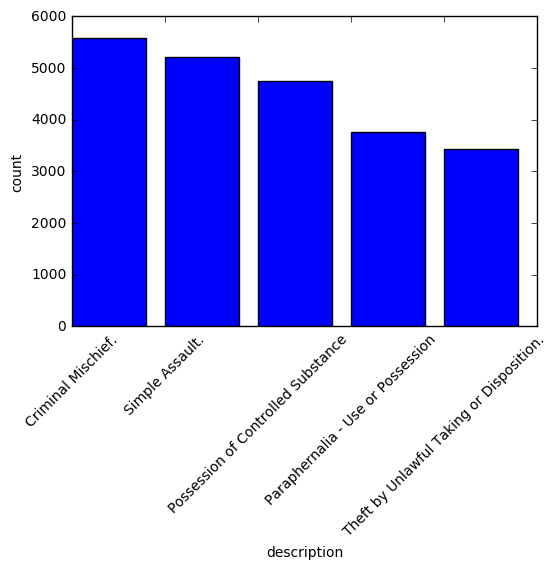

In [41]:
%matplotlib inline
result = _
result.bar()

Our top five most frequen crimes are criminal mischief, simple assault, possession of controlled substance, paraphernalia-use or possession, and theft by unlawful taking or disposition.

Perhaps more interestingly, we can analyze the dates and times of crimes. Let's see if more crimes are committed on the weekends.

In [42]:
%%sql
SELECT a.is_weekend, COUNT(*) 
FROM time_dimension a, crime_fact b
WHERE a.time_key = b.time_key
GROUP BY is_weekend
ORDER BY COUNT DESC;

2 rows affected.


is_weekend,count
False,84319
True,32789


The theory that more crimes are committed on the weekends is wrong. However, it does look like PROPORTIONALLY, more crimes are committed on the weekends. Let's break this down by the day of the week to see which days have the most crime.

In [43]:
%%sql
SELECT a.day_of_week_str, COUNT(*) 
FROM time_dimension a, crime_fact b
WHERE a.time_key = b.time_key
GROUP BY day_of_week_str
ORDER BY CASE WHEN day_of_week_str = 'Sunday' THEN '1'
              WHEN day_of_week_str = 'Monday' THEN '2'
              WHEN day_of_week_str = 'Tuesday' THEN '3'
              WHEN day_of_week_str = 'Wednesday' THEN '4'
              WHEN day_of_week_str = 'Thursday' THEN '5'
              WHEN day_of_week_str = 'Friday' THEN '6'
              WHEN day_of_week_str = 'Saturday' THEN '7'
              ELSE day_of_week_str END ASC;

7 rows affected.


day_of_week_str,count
Sunday,15675
Monday,16093
Tuesday,17099
Wednesday,17042
Thursday,16704
Friday,17381
Saturday,17114


<Container object of 7 artists>

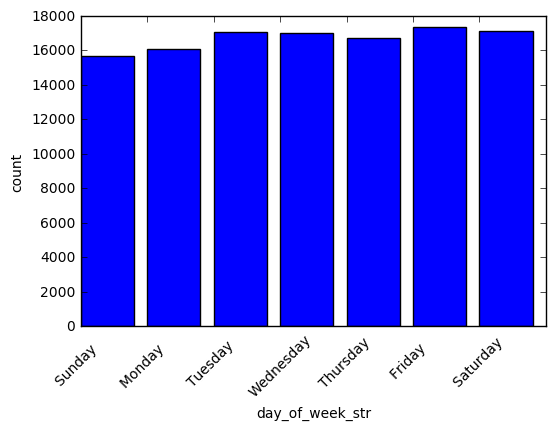

In [44]:
%matplotlib inline
result = _
result.bar()

Interestingly enough, Friday, a weekday, is the most common for crime. However, Saturday, a weekend day, is the next highest.

Now let's see if the year makes a difference. Of course, we only have 10.5 months out of 2016 since as of writing this notebook, it is mid-November 2016.

In [45]:
%%sql
SELECT year, COUNT(*) 
FROM time_dimension a, crime_fact b
WHERE a.time_key = b.time_key
GROUP BY a.year
ORDER BY year;

2 rows affected.


year,count
2015,59803
2016,57305


<Container object of 2 artists>

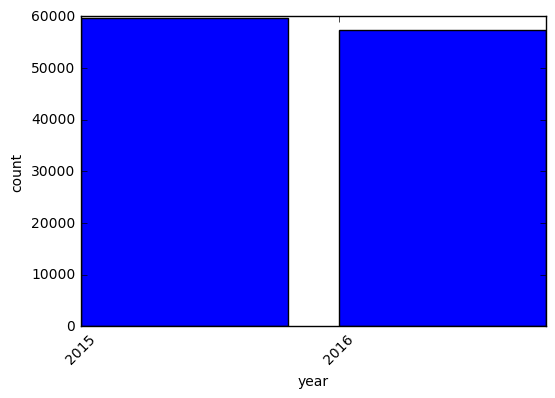

In [46]:
%matplotlib inline
result = _
result.bar()

It looks like both years have approximately the same amount of crime. Does the month make a difference?

In [47]:
%%sql
SELECT month, COUNT(*) 
FROM time_dimension a, crime_fact b
WHERE a.time_key = b.time_key
GROUP BY a.month
ORDER BY month;

12 rows affected.


month,count
1,5839
2,5619
3,9112
4,10304
5,11908
6,12365
7,12732
8,13469
9,12004
10,11862


<Container object of 12 artists>

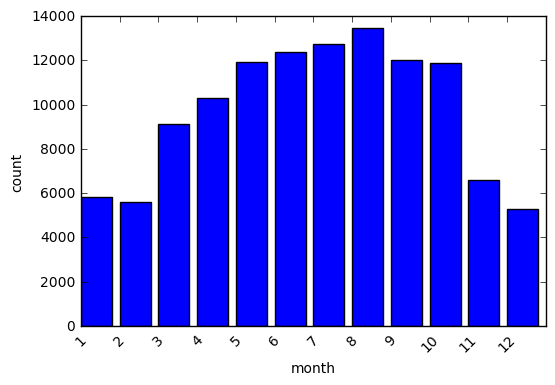

In [48]:
%matplotlib inline
result = _
result.bar()

Here's an interesting observation! It looks like the summer months have the most crime, and the winter months have the least crime. 

Let's look at just the summer months (month = 6, 7, or 8). Does the day of the week make a difference there?

In [49]:
%%sql
SELECT a.day_of_week_str, COUNT(*) 
FROM time_dimension a, crime_fact b
WHERE a.time_key = b.time_key
AND (a.month = 6 OR a.month = 7 OR a.month = 8)
GROUP BY day_of_week_str
ORDER BY COUNT DESC;

7 rows affected.


day_of_week_str,count
Wednesday,5845
Saturday,5649
Monday,5611
Tuesday,5578
Thursday,5330
Sunday,5280
Friday,5273


Wow! Friday, our most crime-filled day of the week overall, actually has the least crime in the summertime. Hopefully people are out doing fun things instead of committing crimes on those days.

Does day of the month have anything to do with crime? Maybe people commit fewer crimes on paydays, like the last day of the year?

In [50]:
%%sql
SELECT day, COUNT(*) 
FROM time_dimension a, crime_fact b
WHERE a.time_key = b.time_key
GROUP BY a.day
ORDER BY day;

31 rows affected.


day,count
1,4411
2,3936
3,3321
4,3564
5,3202
6,3841
7,3596
8,3589
9,3541
10,3901


<Container object of 31 artists>

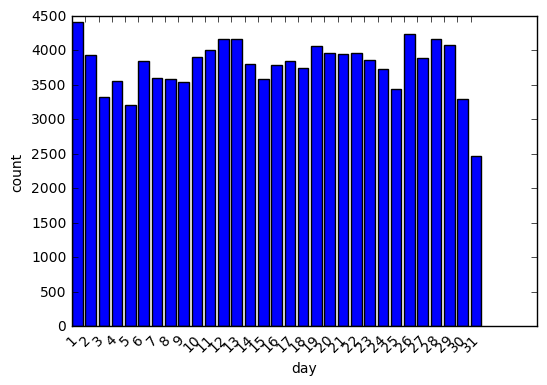

In [51]:
%matplotlib inline
result = _
result.bar()

Well, it does seem that the last day of the month has fewer crimes, but that could also be attributed to fewer months having 31 days. It is interesting to note that the first day seems to have the most crimes, but other than that it seems pretty random.

Last, we'll check out the hour of the day. We hypothesize that crimes occur more often in certain hours (say, the evening) than midday.

In [52]:
%%sql
SELECT hour_24, COUNT(*) 
FROM time_dimension a, crime_fact b
WHERE a.time_key = b.time_key
GROUP BY a.hour_24
ORDER BY a.hour_24;

24 rows affected.


hour_24,count
0,5956
1,6486
2,6214
3,4025
4,2269
5,1571
6,2150
7,2855
8,3638
9,3938


<Container object of 24 artists>

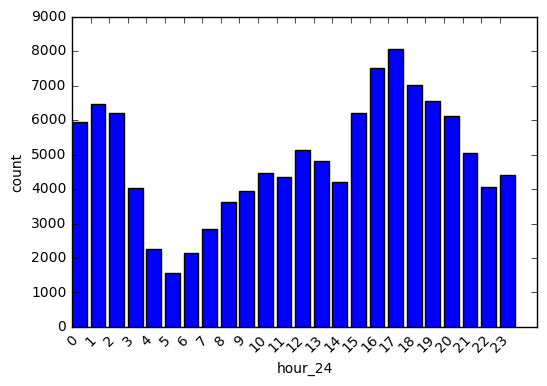

In [53]:
%matplotlib inline
result = _
result.bar()

Wow! It looks like the saying, "Nothing good happens after midnight" holds true. There is a LOT of crime between midnight and 3 am! Also, our hypothesis appears to be correct-- the evening hours seem to have more crime than the daytime hours, particularly between 4 and 8 pm.

## Bonus (10 points for one of A or B)


### Option A - Automating ETL

Consider the work you did to load your original raw dataset and then transform it into a dimensional model for analysis.  What would it take to automate this process?  How often would you need to update the data?  Could you easily automate any data cleaning steps?  What checks would you need to put in place to ensure quality?  Would humans need to be involved, or could you automate it all?

Discuss.


### Option B - Augmenting dimensions

Considering your dimensional model, what external data could you find to augment it?  As in the case of bike trips, where weather might provide an interesting added dimension/context not present in the original data, you can probably find another source of data to complement your own model.  Identify one such source and add it to your model, demonstrating its value with a few new queries.

### Option A

First, a new record should be inserted into time_dimension every hour with a time_key to account for the hour. Dimensions should contain all possibilities, even if no fact row will have that time_key.

To automate insertion of new records for crime into our Star Schema, a system would need to create a new row with the next crime_key in the series. Then, it would need to compare the crime section/description from the ctype_dimension table and populate ctype_key in the fact table with the correct ctype_key from the dimension table. The time_key would need to be put into the new record in the fact table, and we know that there WILL be a row in time_dimension for this hour because every hour, time_dimension gets another row. I believe this could be automated and no human would need to be involved, provided that we don't have any missing values. Additionally, this assumes that there will be no new crime types with a new section and description. If a new crime type were to exist, a record should be inserted when the law is passed or when the section/description is determined so that if any crimes were to occur of this type, the fact table could update with the appropriate ctype_key.


## Attestation

Naveen worked on parts 1 and 2. Kelly worked on parts 2, 3, and 4. We confirm that each team member contributed sufficiently to project 2.